In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## pytorch 설정

In [29]:
import torch

In [30]:
torch.__version__

'2.7.1+cu126'

In [31]:
# 맥북 지원
print(f"MPS 장치를 지원하도록 build가 되었는가? {torch.backends.mps.is_built()}")
print(f"MPS 장치가 사용 가능한가? {torch.backends.mps.is_available()}") 

MPS 장치를 지원하도록 build가 되었는가? False
MPS 장치가 사용 가능한가? False


In [32]:
# MPS 활용한 GPU 사용 가능 여부 확인
device = torch.device('mps:0' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [33]:
# 윈도우

# GPU 사용 가능 여부 확인
print(torch.cuda.is_available())

if torch.cuda.is_available():

    device = torch.device("cuda")

else:

    device = torch.device("cpu")

print(f"Using device: {device}")

True
Using device: cuda


## Word2Vec 구현

In [34]:
import json
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
from tqdm import tqdm # 현재 for문이 얼마나 실행되었는지를 알려주는 라이브러리
import json
# JSON 파일 열기
with open('train_original.json', 'r', encoding='utf-8') as f:
    local = json.load(f)

train_data = []

# 문서(document) 순회
for doc in tqdm(local['documents']):
    # 문장 단위 텍스트는 2중 리스트 구조이므로 두 번 반복
    for paragraph in doc['text']:  # 각 paragraph는 sentence 객체들의 리스트
        for sentence_obj in paragraph:
            sentence = sentence_obj['sentence']
            train_data.append(sentence)

# 확인
print(f"총 문장 수: {len(train_data)}")
print(train_data[:5])
pd_data = pd.DataFrame()
# pd_data['context'] = train_data[:1000]
pd_data['context'] = train_data[:10000]
print(pd_data)
# 정규 표현식을 통해 한글이 아닌경우 제거하는 전처리 수행
# 정규 표현식을 통한 한글 외 문자 제거
pd_data['context'] = pd_data['context'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# 학습 시에 사용하지 않는 불용어 제거, 형태소 분석기를 사용해 각 문장에 대해 토큰화 수행
# 불용어 정의
stopwords = pd.read_csv('./stopwords.csv', index_col=0)

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(pd_data['context']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)
print(tokenized_data[:5])

100%|██████████| 24329/24329 [00:00<00:00, 694771.82it/s]


총 문장 수: 241761
['원고가 소속회사의 노동조합에서 분규가 발생하자 노조활동을 구실로 정상적인 근무를 해태하고,', '노조조합장이 사임한 경우,', '노동조합규약에 동 조합장의 직무를 대행할 자를 규정해 두고 있음에도 원고 자신이 주동하여 노조자치수습대책위원회를 구성하여 그 위원장으로 피선되어 근무시간중에도 노조활동을 벌여 운수업체인 소속회사의 업무에 지장을 초래하고', '종업원들에게도 나쁜 영향을 끼쳐 소속회사가 취업규칙을 위반하고', '고의로 회사업무능률을 저해하였으며 회사업무상의 지휘명령에 위반하였음을 이유로 원고를 징계해고 하였다면,']
                                                context
0     원고가 소속회사의 노동조합에서 분규가 발생하자 노조활동을 구실로 정상적인 근무를 해...
1                                        노조조합장이 사임한 경우,
2     노동조합규약에 동 조합장의 직무를 대행할 자를 규정해 두고 있음에도 원고 자신이 주...
3                    종업원들에게도 나쁜 영향을 끼쳐 소속회사가 취업규칙을 위반하고
4     고의로 회사업무능률을 저해하였으며 회사업무상의 지휘명령에 위반하였음을 이유로 원고를...
...                                                 ...
9995  약정된 보험료를 지급할 의무자이지만 그 지위의 성격과 보험자대위 규정의 취지에 비추...
9996  보험자대위에 있어서 보험계약자와 제3자를 구별하여 취급할 법률상의 이유는 없는 것이...
9997   조세부과처분을 받은 당사자는 스스로 법령을 살피고 제소기간을 계산하여 준수하여야 하고,
9998    국세기본법(1984.8.7. 법률 제3746호로 개정되기 전의 것) 제69조 제3항,
9999  제60조 제2항은 주의적 규정에 지나지 아니하므로 국세심판소장이 그 규정들에 반하여...

[10000 rows x 

100%|██████████| 10000/10000 [00:24<00:00, 406.40it/s]

[['원고', '가', '소', '속', '회사', '의', '노동조합', '에서', '분규', '가', '발생', '하다', '노조', '활동', '을', '구실', '로', '정상', '적', '인', '근무', '를', '해태', '하고', ','], ['노조', '조합', '장이', '사임', '한', '경우', ','], ['노동조합', '규약', '에', '동', '조합', '장', '의', '직무', '를', '대행', '하다', '자르다', '규정', '하다', '두다', '있다', '원고', '자신', '이', '주동', '하다', '노조', '자치', '수습', '대책', '위원회', '를', '구성', '하다', '그', '위원장', '으로', '피선', '되어다', '근무시간', '중', '에도', '노조', '활동', '을', '벌이다', '운수업체', '인', '소', '속', '회사', '의', '업무', '에', '지장', '을', '초래', '하고'], ['종업원', '들', '에게도', '나쁘다', '영향', '을', '끼치다', '소', '속', '회사', '가', '취업규칙', '을', '위반', '하고'], ['고의', '로', '회사', '업무', '능률', '을', '저해', '하다', '회사', '업무', '상의', '지휘명령', '에', '위반', '하다', '음', '을', '이유', '로', '원고', '를', '징계', '해고', '하다', ',']]


In [8]:
# corpus = [
#     'he is a king',
#     'she is a queen',
#     'he is a man',
#     'she is a woman',
#     'warsaw is poland capital',
#     'berlin is germany capital',
#     'paris is france capital',
#     'seoul is korea capital', 
#     'bejing is china capital',
#     'tokyo is japan capital',
# ]
# def tokenize_corpus(corpus):
#     tokens = [x.split() for x in corpus]
#     return tokens
# tokenized_corpus = tokenize_corpus(corpus)

In [35]:
# print(tokenized_corpus)
tokenized_corpus = tokenized_data
print(tokenized_corpus[:3])

[['원고', '가', '소', '속', '회사', '의', '노동조합', '에서', '분규', '가', '발생', '하다', '노조', '활동', '을', '구실', '로', '정상', '적', '인', '근무', '를', '해태', '하고', ','], ['노조', '조합', '장이', '사임', '한', '경우', ','], ['노동조합', '규약', '에', '동', '조합', '장', '의', '직무', '를', '대행', '하다', '자르다', '규정', '하다', '두다', '있다', '원고', '자신', '이', '주동', '하다', '노조', '자치', '수습', '대책', '위원회', '를', '구성', '하다', '그', '위원장', '으로', '피선', '되어다', '근무시간', '중', '에도', '노조', '활동', '을', '벌이다', '운수업체', '인', '소', '속', '회사', '의', '업무', '에', '지장', '을', '초래', '하고']]


In [36]:
vocabulary = []
for sentence in tokenized_corpus:
    for token in sentence:
        if token not in vocabulary:
            vocabulary.append(token)
word2idx = {w: idx for (idx, w) in enumerate(vocabulary)}
idx2word = {idx: w for (idx, w) in enumerate(vocabulary)}
vocabulary_size = len(vocabulary)

In [37]:
window_size = 2
idx_pairs = []
for sentence in tokenized_corpus:
    indices = [word2idx[word] for word in sentence]
    for center_word_pos in range(len(indices)):
        for w in range(-window_size, window_size + 1):
            context_word_pos = center_word_pos + w
            if context_word_pos < 0 or context_word_pos >= len(indices) or center_word_pos == context_word_pos:
                continue
            context_word_idx = indices[context_word_pos]
            idx_pairs.append((indices[center_word_pos], context_word_idx))
idx_pairs = np.array(idx_pairs) 

In [38]:
print(idx_pairs[0:10])

[[0 1]
 [0 2]
 [1 0]
 [1 2]
 [1 3]
 [2 0]
 [2 1]
 [2 3]
 [2 4]
 [3 1]]


In [39]:
# 메모리 오류 -> 원-핫 벡터 대신 임베딩 레이어 사용해야!
# def get_input_layer(word_idx):
#     return np.eye(vocabulary_size)[word_idx]
# def get_input_layer(word_idx):
#     vec = np.zeros(vocabulary_size)
#     vec[word_idx] = 1
#     return vec

# X = []
# y = []
# for data, target in idx_pairs:
#     X.append(get_input_layer(data))
#     y.append(target)
    
# X = torch.FloatTensor(np.array(X))
# y = torch.Tensor(np.array(y)).long()

In [40]:
# X, y를 정수 인덱스 텐서로 만듭니다 (원-핫 인코딩 ❌)
X = torch.LongTensor([data for data, target in idx_pairs])
y = torch.LongTensor([target for data, target in idx_pairs])

In [41]:
vocab_size = vocabulary_size  # 전체 단어 수 (예: 8405)
embedding_dim = 2             # 2차원 시각화를 위해

# 2. 모델 정의
class Word2VecModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.output = nn.Linear(embedding_dim, vocab_size)
        
    def forward(self, x):
        x = self.embedding(x)         # (batch_size, embedding_dim)
        out = self.output(x)          # (batch_size, vocab_size)
        return out

# 3. 모델, 옵티마이저 정의
model = Word2VecModel(vocab_size, embedding_dim)
optimizer = optim.Adam(model.parameters())
nb_epochs = 100

from torch.utils.data import DataLoader, TensorDataset

batch_size = 1024
dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

for epoch in range(nb_epochs + 1):
    total_loss = 0
    for batch_X, batch_y in loader:
        prediction = model(batch_X)
        cost = F.cross_entropy(prediction, batch_y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        total_loss += cost.item()
    
    if epoch % 20 == 0 or epoch == nb_epochs:
        print(f"Epoch {epoch}/{nb_epochs} Loss: {total_loss:.6f}")


Epoch 0/100 Loss: 9007.874458
Epoch 20/100 Loss: 6439.431547
Epoch 40/100 Loss: 6404.986753
Epoch 60/100 Loss: 6394.652259
Epoch 80/100 Loss: 6390.384998
Epoch 100/100 Loss: 6388.209607


In [42]:
import pandas as pd

# 1. 벡터 추출
vector = model.embedding.weight.data  # (vocab_size, 2)

# 2. 인덱스 → 단어 매핑 리스트 생성
vocabulary = [idx2word[i] for i in range(vocab_size)]

# 3. DataFrame 생성
w2v_df = pd.DataFrame(vector.numpy(), columns=['x1', 'x2'])
w2v_df['word'] = vocabulary
w2v_df = w2v_df[['word', 'x1', 'x2']]

# 4. 출력
print(w2v_df.head())


  word        x1        x2
0   원고  0.613468 -0.752526
1    가  0.462427 -1.274420
2    소  0.796357 -0.599823
3    속  0.592397 -0.955768
4   회사  0.674809 -0.449272


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  func(*args, **kwargs)


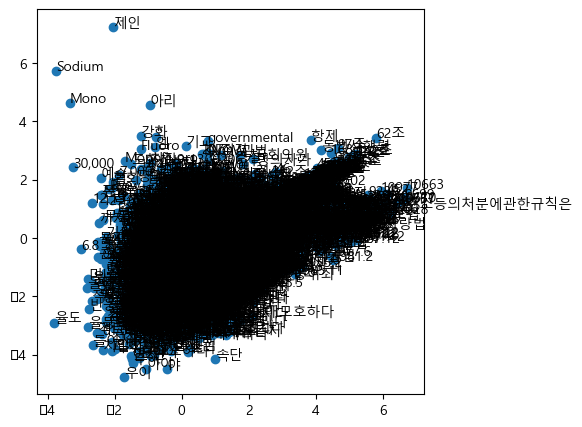

In [47]:
ano = w2v_df['word'].values
x1 = w2v_df['x1'].values
x2 = w2v_df['x2'].values
fig, ax = plt.subplots(figsize=(5,5))
plt.rcParams['font.family'] = 'Malgun Gothic'
ax.scatter(x1, x2)
for i, txt in enumerate(ano):
    ax.annotate(txt, (x1[i], x2[i]))

'경제'의 임베딩 벡터: [-1.1691504  -0.84684896]


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


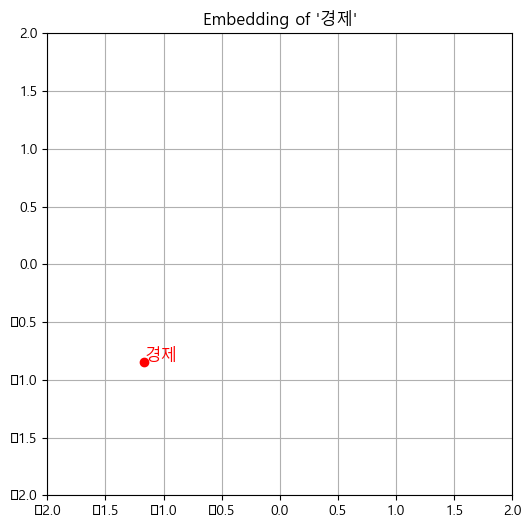

In [46]:
target_word = '경제'
if target_word in word2idx:
    word_idx = word2idx[target_word]
    vector = model.embedding.weight.data[word_idx].numpy()
    print(f"'{target_word}'의 임베딩 벡터:", vector)
else:
    print(f"'{target_word}'는 vocabulary에 존재하지 않습니다.")
plt.figure(figsize=(6, 6))
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.family'] = 'Malgun Gothic'


plt.scatter(vector[0], vector[1], color='red')
plt.text(vector[0]+0.01, vector[1]+0.01, target_word, fontsize=12, color='red')
plt.title(f"Embedding of '{target_word}'")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()


In [48]:
import torch
import torch.nn.functional as F

def get_similar_words(target_word, top_k=10):
    if target_word not in word2idx:
        print(f"'{target_word}'는 vocabulary에 없습니다.")
        return []
    
    # 타겟 단어의 임베딩 벡터
    target_idx = word2idx[target_word]
    target_vector = model.embedding.weight[target_idx]

    # 모든 단어 벡터
    all_vectors = model.embedding.weight

    # 코사인 유사도 계산
    cos_sim = F.cosine_similarity(target_vector.unsqueeze(0), all_vectors, dim=1)

    # 유사도가 높은 top_k 단어 인덱스 추출 (본인 제외)
    sim_scores, sim_indices = torch.topk(cos_sim, top_k + 1)
    sim_indices = sim_indices.tolist()
    sim_scores = sim_scores.tolist()

    # 자기 자신 제외
    sim_words = []
    for i, idx in enumerate(sim_indices):
        word = idx2word[idx]
        if word != target_word:
            sim_words.append((word, sim_scores[i]))
        if len(sim_words) == top_k:
            break

    return sim_words


In [54]:
similar_words = get_similar_words('경제', top_k=10)
for word, score in similar_words:
    print(f"{word}: {score:.8f}")


빌다: 1.00000000
미연: 0.99999952
대집행: 0.99999917
질물: 0.99999869
습성: 0.99999845
임금: 0.99999774
가혹: 0.99999750
학계: 0.99999487
작자: 0.99999440
혼란: 0.99999380


In [50]:
def visualize_similar_words(target_word, top_k=10):
    similar_words = get_similar_words(target_word, top_k=top_k)

    if not similar_words:
        return

    # 타겟 단어 포함한 단어 리스트
    words = [target_word] + [word for word, _ in similar_words]
    vectors = [model.embedding.weight[word2idx[word]].detach().numpy() for word in words]

    x = [vec[0] for vec in vectors]
    y = [vec[1] for vec in vectors]

    plt.figure(figsize=(8, 8))
    plt.scatter(x, y, color='blue')
    plt.scatter(x[0], y[0], color='red')  # 타겟 단어 강조

    for i, word in enumerate(words):
        plt.text(x[i] + 0.01, y[i] + 0.01, word, fontsize=12)

    plt.title(f"'{target_word}'와 유사한 단어 시각화")
    plt.grid(True)
    plt.show()


C:\Users\user\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  fig.canvas.print_figure(bytes_io, **kw)


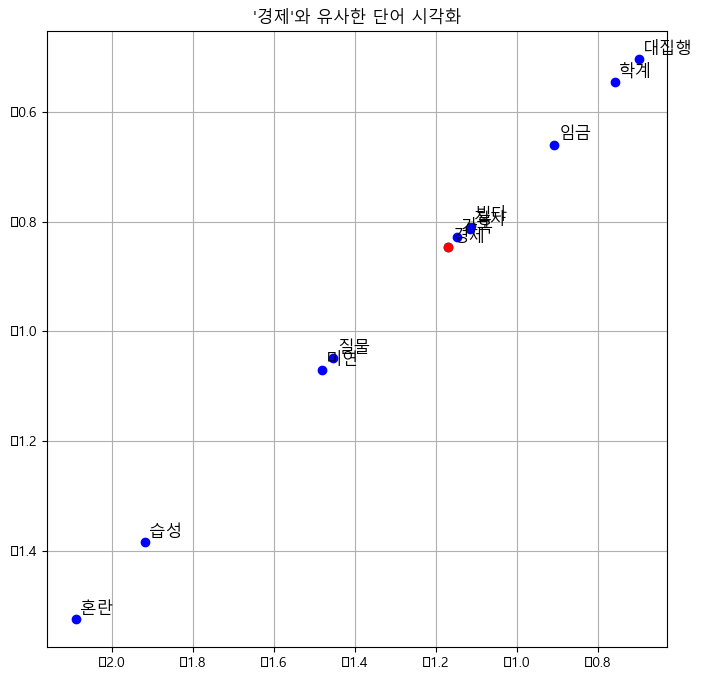

In [52]:
visualize_similar_words('경제', top_k=10)


In [56]:
# 모델 저장
torch.save(model.state_dict(), 'skipgram_model.pt')
print("모델이 'skipgram_model.pt'로 저장되었습니다.")


모델이 'skipgram_model.pt'로 저장되었습니다.


## Word2Vec (gensim)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt
from tqdm import tqdm # 현재 for문이 얼마나 실행되었는지를 알려주는 라이브러리
import json

In [6]:
import json
from tqdm import tqdm

# JSON 파일 열기
with open('train_original.json', 'r', encoding='utf-8') as f:
    local = json.load(f)

train_data = []

# 문서(document) 순회
for doc in tqdm(local['documents']):
    # 문장 단위 텍스트는 2중 리스트 구조이므로 두 번 반복
    for paragraph in doc['text']:  # 각 paragraph는 sentence 객체들의 리스트
        for sentence_obj in paragraph:
            sentence = sentence_obj['sentence']
            train_data.append(sentence)

# 확인
print(f"총 문장 수: {len(train_data)}")
print(train_data[:5])

100%|██████████| 24329/24329 [00:00<00:00, 725094.13it/s]

총 문장 수: 241761
['원고가 소속회사의 노동조합에서 분규가 발생하자 노조활동을 구실로 정상적인 근무를 해태하고,', '노조조합장이 사임한 경우,', '노동조합규약에 동 조합장의 직무를 대행할 자를 규정해 두고 있음에도 원고 자신이 주동하여 노조자치수습대책위원회를 구성하여 그 위원장으로 피선되어 근무시간중에도 노조활동을 벌여 운수업체인 소속회사의 업무에 지장을 초래하고', '종업원들에게도 나쁜 영향을 끼쳐 소속회사가 취업규칙을 위반하고', '고의로 회사업무능률을 저해하였으며 회사업무상의 지휘명령에 위반하였음을 이유로 원고를 징계해고 하였다면,']


In [7]:
pd_data = pd.DataFrame()
# pd_data['context'] = train_data[:1000]
pd_data['context'] = train_data[:50000]
print(pd_data)

                                                 context
0      원고가 소속회사의 노동조합에서 분규가 발생하자 노조활동을 구실로 정상적인 근무를 해...
1                                         노조조합장이 사임한 경우,
2      노동조합규약에 동 조합장의 직무를 대행할 자를 규정해 두고 있음에도 원고 자신이 주...
3                     종업원들에게도 나쁜 영향을 끼쳐 소속회사가 취업규칙을 위반하고
4      고의로 회사업무능률을 저해하였으며 회사업무상의 지휘명령에 위반하였음을 이유로 원고를...
...                                                  ...
49995  나. 관습법상 법정지상권이란 토지와 건물을 각 소유권의 객체인 별개의 부동산으로 보...
49996  환지처분전 체비지 매수인이 체비지를 인도받아 물권 유사의 사용수익권을 취득하였다 하...
49997  구 민법(1990.1.13. 법률 제4199호로 개정전)하에서 망부와 을녀와의 혼인...
49998                          위 출생신고는 최소한 인지의 효력을 가지므로,
49999  갑은 상속개시 당시 망부에 의해 인지된 혼인외 출생자에 대하여 같은 법 제774조에...

[50000 rows x 1 columns]


In [8]:
# 정규 표현식을 통해 한글이 아닌경우 제거하는 전처리 수행
# 정규 표현식을 통한 한글 외 문자 제거
pd_data['context'] = pd_data['context'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# 학습 시에 사용하지 않는 불용어 제거, 형태소 분석기를 사용해 각 문장에 대해 토큰화 수행
# 불용어 정의
stopwords = pd.read_csv('./stopwords.csv', index_col=0)

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(pd_data['context']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)


100%|██████████| 50000/50000 [01:46<00:00, 469.75it/s]


In [69]:
print(tokenized_data[:5])

[['원고', '가', '소', '속', '회사', '의', '노동조합', '에서', '분규', '가', '발생', '하다', '노조', '활동', '을', '구실', '로', '정상', '적', '인', '근무', '를', '해태', '하고', ','], ['노조', '조합', '장이', '사임', '한', '경우', ','], ['노동조합', '규약', '에', '동', '조합', '장', '의', '직무', '를', '대행', '하다', '자르다', '규정', '하다', '두다', '있다', '원고', '자신', '이', '주동', '하다', '노조', '자치', '수습', '대책', '위원회', '를', '구성', '하다', '그', '위원장', '으로', '피선', '되어다', '근무시간', '중', '에도', '노조', '활동', '을', '벌이다', '운수업체', '인', '소', '속', '회사', '의', '업무', '에', '지장', '을', '초래', '하고'], ['종업원', '들', '에게도', '나쁘다', '영향', '을', '끼치다', '소', '속', '회사', '가', '취업규칙', '을', '위반', '하고'], ['고의', '로', '회사', '업무', '능률', '을', '저해', '하다', '회사', '업무', '상의', '지휘명령', '에', '위반', '하다', '음', '을', '이유', '로', '원고', '를', '징계', '해고', '하다', ',']]


In [70]:
# 모델 정의
from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

# 모델 저장
from gensim.models import KeyedVectors
model.wv.save_word2vec_format('skip_gram_model') 

# 코렙에 모델 저장
# torch.savq 메소스 사용
import torch
model_save_name = 'skip_gram_model' 
path = f"./{model_save_name}"  # 현재 폴더에 저장

torch.save(model, path)

In [71]:
# Word2Vec 임베딩 행렬 크기 확인
model.wv.vectors.shape

(2815, 100)

In [72]:
# 유사한 단어 추출
print(model.wv.most_similar("노동"))

[('일용', 0.9963839054107666), ('이혼', 0.9911960363388062), ('손금', 0.9908611178398132), ('장래', 0.9904849529266357), ('상당', 0.9903444051742554), ('향', 0.9899176359176636), ('손해배상', 0.9893412590026855), ('객관성', 0.9892339110374451), ('바로', 0.989116370677948), ('별개', 0.9884136319160461)]


/opt/anaconda3/envs/test/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


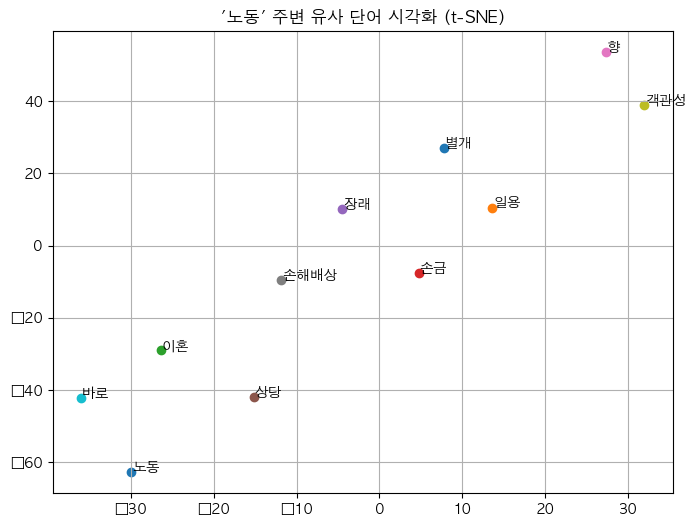

In [73]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# 유사 단어 추출
target_word = "노동"
similar_words = model.wv.most_similar(target_word, topn=10)

# 유사 단어 리스트 + 타겟 단어 포함
words = [target_word] + [w for w, _ in similar_words]

# 각 단어에 대한 벡터 추출
word_vectors = np.array([model.wv[w] for w in words])

# 차원 축소 (2D)
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
word_vec_2d = tsne.fit_transform(word_vectors)

# 시각화
plt.figure(figsize=(8, 6))
plt.rcParams['font.family'] = 'AppleGothic'
for i, word in enumerate(words):
    x, y = word_vec_2d[i]
    plt.scatter(x, y)
    plt.annotate(word, (x + 0.1, y + 0.1))

plt.title(f"'{target_word}' 주변 유사 단어 시각화 (t-SNE)")
plt.grid(True)
plt.show()